# Energy Economics, Spring 2019
## Morten Rasmussen, Christian Sørensen

## Preamble

In [1]:
import csv
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
from datetime import datetime
import xlrd
import numpy as np
import pandas as pd
import random
from scipy.interpolate import interp1d
import seaborn as sns; sns.set()


In [1]:
test = 1 + 2

## Data gathering and cleaning

In [2]:
#%% Data gathering and cleaning

# price_data = []
# for x in range(2016, 2019):
#     url = 'https://www.nordpoolgroup.com/globalassets/marketdata-excel-files/elspot-prices_'+str(x)+'_hourly_dkk.xls'
#     urlretrieve(url,'elspot-prices_'+str(x)+'_hourly_dkk.xls')
#     filename='elspot-prices_'+str(x)+'_hourly_dkk.XLS'
#     data= pd.read_html(filename)
#     data=pd.DataFrame(data[0])
#     data=data.iloc[:,[0,1,8,9]]
#     data.columns=['date','time', 'DK_vest_pris', 'DK_øst_pris']
#     price_data.append(data)

# price_data = pd.concat(price_data, axis=0)

# Retrieve forecast data from nordpoolgroup.com. 
forecast_data = []
for x in range(2013, 2014):
    url = 'https://www.nordpoolgroup.com/globalassets/marketdata-excel-files/wind-power-dk-prognosis_'+str(x)+'_hourly.xls'
    urlretrieve(url,'wind-power-dk-prognosis_'+str(x)+'_hourly.xls')
    filename='wind-power-dk-prognosis_'+str(x)+'_hourly.xls'
    data= pd.read_html(filename)
    data=pd.DataFrame(data[0])
    data.columns=['date','time', 'DK_vest_forecast', 'DK_øst_forecast']
    forecast_data.append(data)

forecast_data = pd.concat(forecast_data, axis=0)

# Retrieve production data from nordpoolgroup.com
production_data = []
for x in range(2013, 2014):
    url = 'https://www.nordpoolgroup.com/globalassets/marketdata-excel-files/wind-power-dk_'+str(x)+'_hourly.xls'
    urlretrieve(url,'wind-power-dk_'+str(x)+'_hourly.xls')
    filename='wind-power-dk_'+str(x)+'_hourly.xls'
    data= pd.read_html(filename)
    data=pd.DataFrame(data[0])
    data.columns=['date','time', 'DK_vest_production', 'DK_øst_production']
    production_data.append(data)

production_data = pd.concat(production_data, axis=0)







In [3]:
# Merge forecast and production data, and extract year, month, weekday, hour:
data=pd.merge(forecast_data, production_data, on=['date','time'], indicator = True)
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.date

data['month'] = pd.DatetimeIndex(data['date']).month
data['day'] = pd.DatetimeIndex(data['date']).day
data['year'] = pd.DatetimeIndex(data['date']).year
data['weekday'] = pd.DatetimeIndex(data['date']).weekday
data['hour']=data['time'].str.slice(0, 2)
data.hour = data.hour.astype(int)

# Calculate forecasting error in each price area
data['forecasting_error_øst']=data['DK_øst_forecast']-data['DK_øst_production']
data['forecasting_error_vest']=data['DK_vest_forecast']-data['DK_vest_production']

# Inspect data
data[data["_merge"] != "both"]





,date,time,DK_vest_forecast,DK_øst_forecast,DK_vest_production,DK_øst_production,_merge,month,day,year,weekday,hour,forecasting_error_øst,forecasting_error_vest


In [4]:
data.drop(labels = "_merge", axis = 1)

,date,time,DK_vest_forecast,DK_øst_forecast,DK_vest_production,DK_øst_production,month,day,year,weekday,hour,forecasting_error_øst,forecasting_error_vest
0,2013-01-01,00 - 01,1968.0,830.0,1941.0,893.0,1,1,2013,1,0,-63.0,27.0
1,2013-01-01,01 - 02,1599.0,818.0,1446.0,885.0,1,1,2013,1,1,-67.0,153.0
2,2013-01-01,02 - 03,1238.0,798.0,1041.0,850.0,1,1,2013,1,2,-52.0,197.0
3,2013-01-01,03 - 04,941.0,765.0,867.0,818.0,1,1,2013,1,3,-53.0,74.0
4,2013-01-01,04 - 05,709.0,718.0,687.0,755.0,1,1,2013,1,4,-37.0,22.0
5,2013-01-01,05 - 06,520.0,663.0,592.0,681.0,1,1,2013,1,5,-18.0,-72.0
6,2013-01-01,06 - 07,401.0,611.0,562.0,623.0,1,1,2013,1,6,-12.0,-161.0
7,2013-01-01,07 - 08,347.0,561.0,493.0,580.0,1,1,2013,1,7,-19.0,-146.0
8,2013-01-01,08 - 09,332.0,516.0,574.0,544.0,1,1,2013,1,8,-28.0,-242.0
9,2013-01-01,09 - 10,346.0,473.0,579.0,515.0,1,1,2013,1,9,-42.0,-233.0


In [5]:
# Split data sets according to price area
data_vest=data[['date','hour','day','weekday','year', 'month', 'DK_vest_production','DK_vest_forecast','forecasting_error_vest'] ]
data_øst=data[['date','hour','day','weekday','year','month', 'DK_øst_production','DK_øst_forecast','forecasting_error_øst'] ]

In [6]:
# Load market data from energidataservice. Note, that this reads from a local file .xlsx file. 
# Key variables are Elbas price (min, max, avg), spot prices and date (hourly)
prices= pd.read_excel("Nordpool_Market_Data.xlsx")
prices['date'] = pd.to_datetime(prices['HourDK'])
prices['hour'] = pd.DatetimeIndex(prices['date']).hour
prices['date'] = prices['date'].dt.date
prices['price_diff'] = prices["ElbasAveragePriceDKK"]-prices["SpotPriceDKK"]

# Construct dataset pertaining to price area 1 (west)
prices_vest=prices[prices['PriceArea']=='DK1']

# Merge price-data with wind-data: 
final_vest=pd.merge(prices_vest, data_vest, on=['date','hour'], indicator = True)


In [7]:
final_vest["_merge"].describe()

count     8766
unique       1
top       both
freq      8766
Name: _merge, dtype: object

In [8]:
final_vest[final_vest["_merge"] == "left"]

,HourUTC,HourDK,PriceArea,SpotPurchase,SpotSale,SpotPriceDKK,ElbasAveragePriceDKK,ElbasMaxPriceDKK,ElbasMinPriceDKK,SpotPriceEUR,...,hour,price_diff,day,weekday,year,month,DK_vest_production,DK_vest_forecast,forecasting_error_vest,_merge


In [35]:

final_vest['ElbasAveragePriceDKK']=final_vest['ElbasAveragePriceDKK'].fillna(0)
final_vest['ElbasAveragePriceDKK'] = pd.to_numeric(final_vest['ElbasAveragePriceDKK'])
final_vest["price_diff"] = final_vest["ElbasAveragePriceDKK"]-final_vest["SpotPriceDKK"]
final_vest.loc[final_vest["ElbasAveragePriceDKK"] == 0, "price_diff"] = 0


In [37]:
final_vest.head(50)

,HourUTC,HourDK,PriceArea,SpotPurchase,SpotSale,SpotPriceDKK,ElbasAveragePriceDKK,ElbasMaxPriceDKK,ElbasMinPriceDKK,SpotPriceEUR,...,hour,price_diff,day,weekday,year,month,DK_vest_production,DK_vest_forecast,forecasting_error_vest,_merge
0,2013-12-31 22:00:00,2013-12-31 23:00:00,DK1,829.7,2476.6,185.80,0.00,NaN,NaN,24.91,...,23,0.00,31,1,2013,12,1702.0,2066.0,364.0,both
1,2013-12-31 21:00:00,2013-12-31 22:00:00,DK1,876.5,2402.0,214.60,106.18,108.17,105.19,28.77,...,22,-108.42,31,1,2013,12,1809.0,2105.0,296.0,both
2,2013-12-31 20:00:00,2013-12-31 21:00:00,DK1,990.8,2779.3,149.63,0.00,NaN,NaN,20.06,...,21,0.00,31,1,2013,12,1817.0,2107.0,290.0,both
3,2013-12-31 19:00:00,2013-12-31 20:00:00,DK1,1055.7,2998.7,209.97,0.00,NaN,NaN,28.15,...,20,0.00,31,1,2013,12,1822.0,2102.0,280.0,both
4,2013-12-31 18:00:00,2013-12-31 19:00:00,DK1,1677.9,2490.4,226.01,233.59,253.65,216.35,30.30,...,19,7.58,31,1,2013,12,1824.0,2072.0,248.0,both
5,2013-12-31 17:00:00,2013-12-31 18:00:00,DK1,1886.4,2468.8,231.15,0.00,NaN,NaN,30.99,...,18,0.00,31,1,2013,12,1761.0,1993.0,232.0,both
6,2013-12-31 16:00:00,2013-12-31 17:00:00,DK1,2023.5,2373.7,235.70,0.00,NaN,NaN,31.60,...,17,0.00,31,1,2013,12,1598.0,1867.0,269.0,both
7,2013-12-31 15:00:00,2013-12-31 16:00:00,DK1,2111.9,2340.1,233.24,0.00,NaN,NaN,31.27,...,16,0.00,31,1,2013,12,1441.0,1719.0,278.0,both
8,2013-12-31 14:00:00,2013-12-31 15:00:00,DK1,1253.9,2634.9,225.71,0.00,NaN,NaN,30.26,...,15,0.00,31,1,2013,12,1392.0,1602.0,210.0,both
9,2013-12-31 13:00:00,2013-12-31 14:00:00,DK1,1717.5,2226.9,226.38,0.00,NaN,NaN,30.35,...,14,0.00,31,1,2013,12,1515.0,1551.0,36.0,both


In [39]:
final_vest.head()

,HourUTC,HourDK,PriceArea,SpotPurchase,SpotSale,SpotPriceDKK,ElbasAveragePriceDKK,ElbasMaxPriceDKK,ElbasMinPriceDKK,SpotPriceEUR,...,hour,price_diff,day,weekday,year,month,DK_vest_production,DK_vest_forecast,forecasting_error_vest,_merge
0,2013-12-31 22:00:00,2013-12-31 23:00:00,DK1,829.7,2476.6,185.80,0.00,NaN,NaN,24.91,...,23,0.00,31,1,2013,12,1702.0,2066.0,364.0,both
1,2013-12-31 21:00:00,2013-12-31 22:00:00,DK1,876.5,2402.0,214.60,106.18,108.17,105.19,28.77,...,22,-108.42,31,1,2013,12,1809.0,2105.0,296.0,both
2,2013-12-31 20:00:00,2013-12-31 21:00:00,DK1,990.8,2779.3,149.63,0.00,NaN,NaN,20.06,...,21,0.00,31,1,2013,12,1817.0,2107.0,290.0,both
3,2013-12-31 19:00:00,2013-12-31 20:00:00,DK1,1055.7,2998.7,209.97,0.00,NaN,NaN,28.15,...,20,0.00,31,1,2013,12,1822.0,2102.0,280.0,both
4,2013-12-31 18:00:00,2013-12-31 19:00:00,DK1,1677.9,2490.4,226.01,233.59,253.65,216.35,30.30,...,19,7.58,31,1,2013,12,1824.0,2072.0,248.0,both


In [40]:
final_vest.describe()

,SpotPurchase,SpotSale,SpotPriceDKK,ElbasAveragePriceDKK,ElbasMaxPriceDKK,ElbasMinPriceDKK,SpotPriceEUR,ElbasAveragePriceEUR,ElbasMaxPriceEUR,ElbasMinPriceEUR,hour,price_diff,day,weekday,year,month,DK_vest_production,DK_vest_forecast,forecasting_error_vest
count,8766.000000,8766.000000,8766.000000,8766.000000,6831.000000,6831.000000,8766.000000,6831.000000,6831.000000,6831.000000,8766.000000,8766.000000,8766.000000,8766.000000,8766.0,8766.000000,8765.000000,8766.000000,8765.000000
mean,1549.410370,2020.463541,290.528862,227.110527,310.558501,273.170174,38.958952,39.078884,41.641831,36.628590,11.493498,-2.978703,15.727812,2.996578,2013.0,6.529204,967.635596,973.050764,5.436167
std,600.501698,618.536674,350.635547,146.365927,102.249157,91.208737,47.030473,12.535610,13.710661,12.229751,6.924671,333.793258,8.797996,2.000967,0.0,3.448058,774.620419,794.475615,205.015877
min,407.400000,483.100000,-462.840000,-426.100000,-123.100000,-447.670000,-62.030000,-57.110000,-16.500000,-60.000000,0.000000,-14282.450000,1.000000,0.000000,2013.0,1.000000,7.000000,17.000000,-1237.000000
25%,1073.025000,1580.275000,240.302500,149.220000,253.610000,228.265000,32.230000,32.440000,34.000000,30.600000,5.000000,-8.137500,8.000000,1.000000,2013.0,4.000000,330.000000,326.000000,-92.000000
50%,1432.400000,2018.050000,275.580000,260.440000,291.580000,268.520000,36.950000,37.620000,39.100000,36.000000,11.000000,0.000000,16.000000,3.000000,2013.0,7.000000,744.000000,720.000000,8.000000
75%,1920.375000,2438.475000,321.060000,312.520000,350.395000,313.290000,43.067500,44.490000,47.000000,42.000000,17.000000,13.010000,23.000000,5.000000,2013.0,10.000000,1481.000000,1470.750000,101.000000
max,3639.300000,4100.700000,14910.800000,1735.470000,2237.460000,1305.190000,2000.000000,232.690000,300.000000,175.000000,23.000000,1249.980000,31.000000,6.000000,2013.0,12.000000,3345.000000,3323.000000,1257.000000


In [59]:
## Forecasting error and price difference
from sklearn.linear_model import LinearRegression

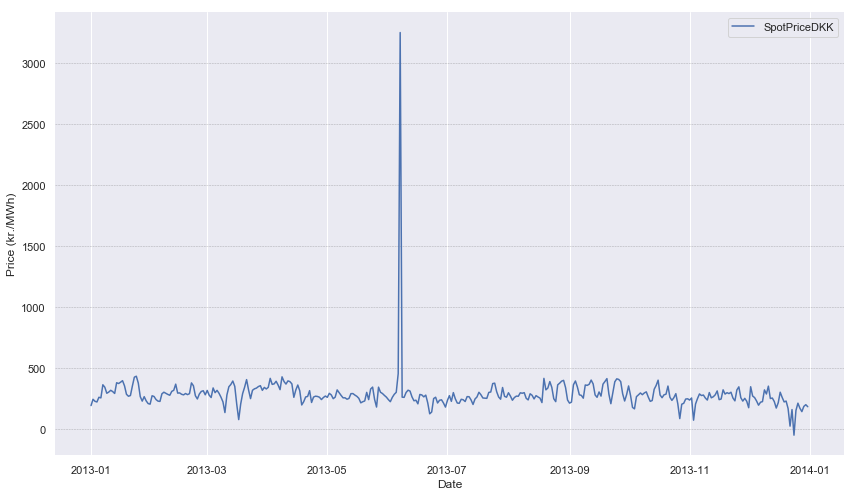

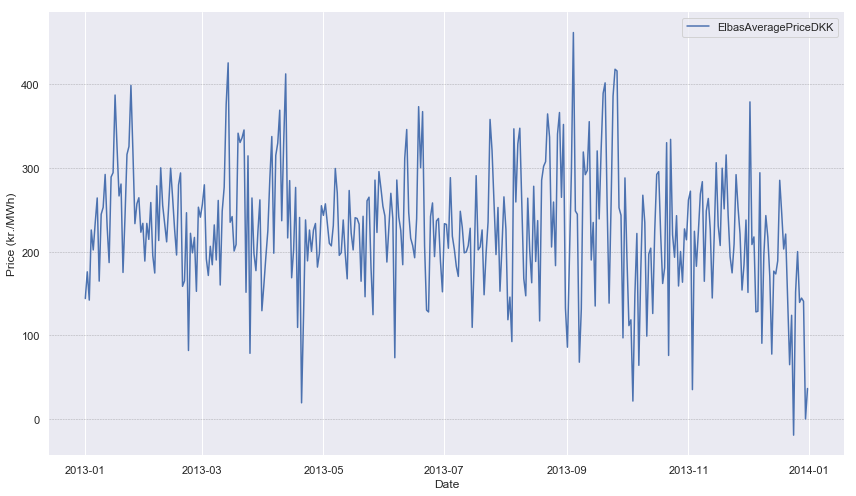

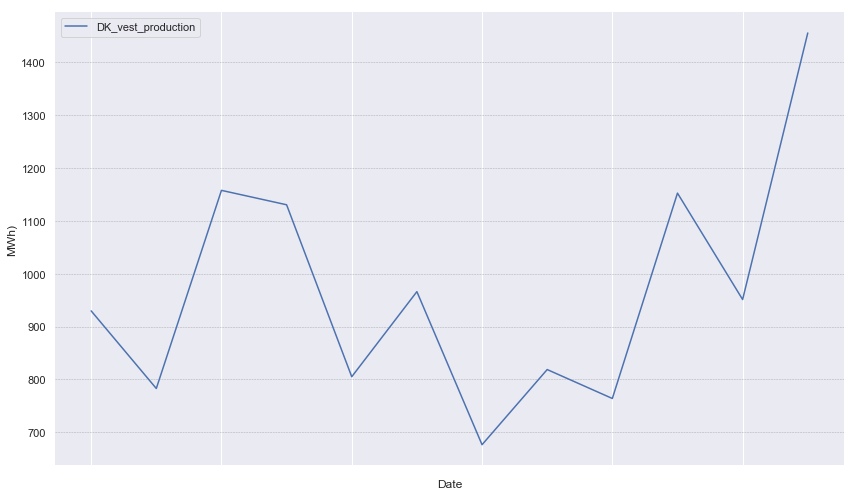

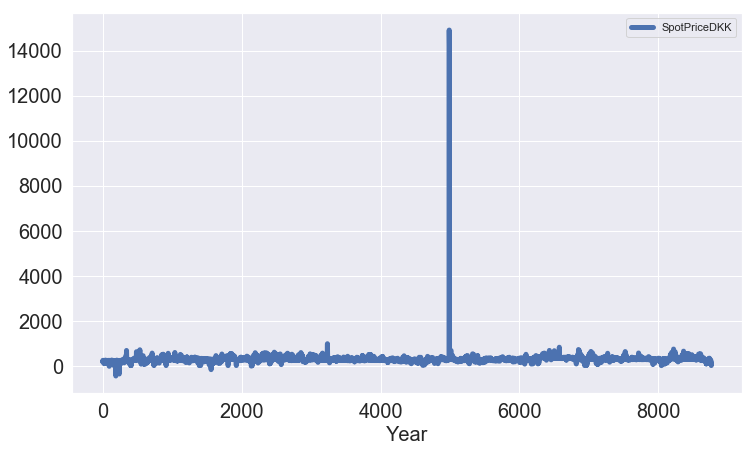

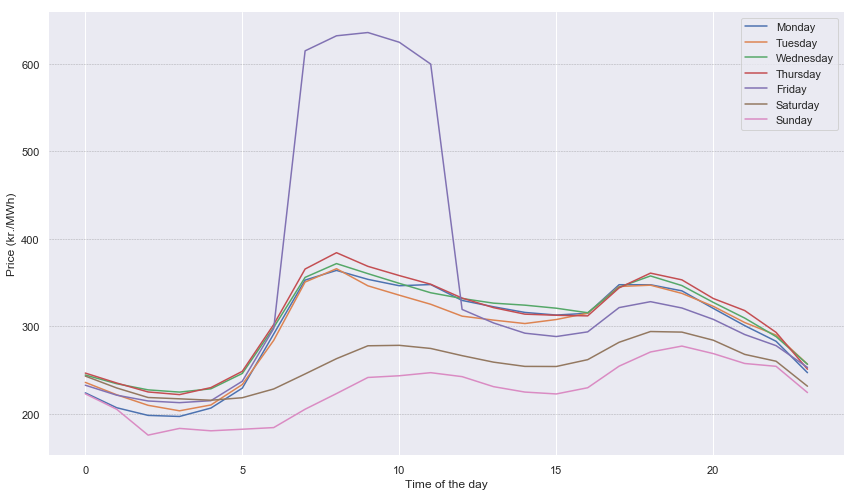

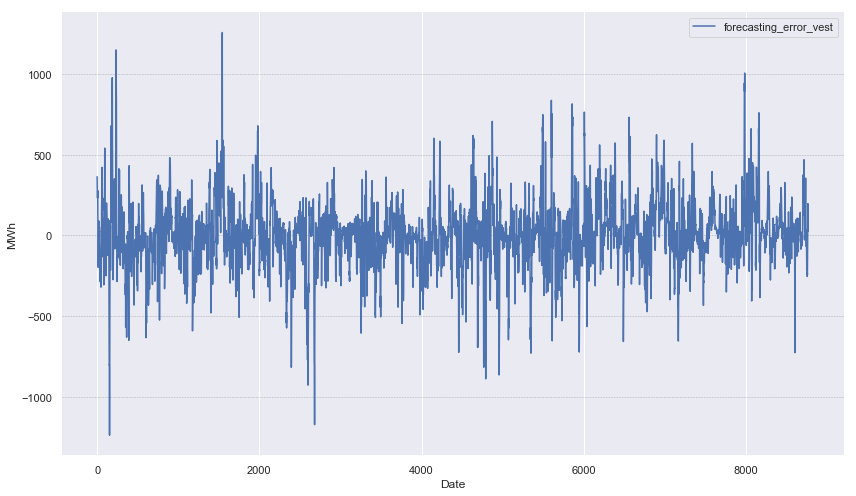

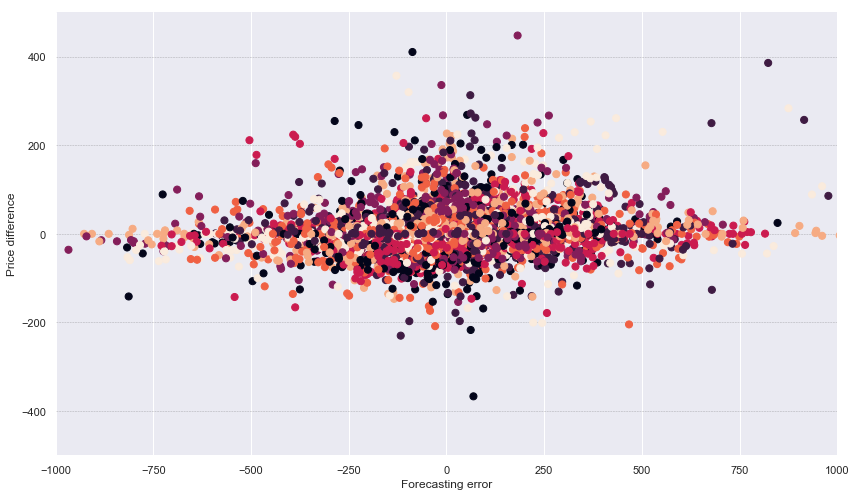

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


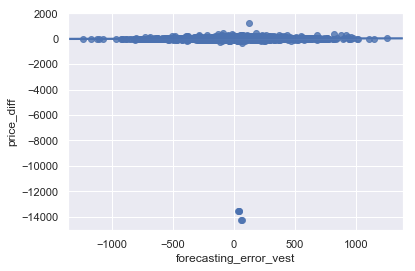

In [62]:
#%% Data description
#Overall development in prices, daily
fig, ax = plt.subplots(figsize=(12,7))
final_vest.groupby(['date']).mean()[['SpotPriceDKK']].plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Price (kr./MWh)')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()

#Overall development in prices, daily
fig, ax = plt.subplots(figsize=(12,7))
final_vest.groupby(['date']).mean()[['ElbasAveragePriceDKK']].plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Price (kr./MWh)')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()

#Overall development in wind power production, monthly
fig, ax = plt.subplots(figsize=(12,7))
final_vest.groupby(['year','month']).mean()[['DK_vest_production']].plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('MWh)')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()


#Over 24 hours
final_vest[['SpotPriceDKK']].plot(figsize=(12,7), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

fig, ax = plt.subplots(figsize=(12,7))
final_vest.groupby(['hour','weekday']).mean()['SpotPriceDKK'].unstack().plot(ax=ax)
plt.legend(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xlabel('Time of the day')
plt.ylabel('Price (kr./MWh)')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()

#Prediction errors
fig, ax = plt.subplots(figsize=(12,7))
final_vest[['forecasting_error_vest']].plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('MWh')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()



fig, ax = plt.subplots(figsize=(12,7))
plt.scatter(final_vest.forecasting_error_vest, final_vest.price_diff, s=50, c=final_vest.weekday)
plt.xlabel('Forecasting error')
plt.ylabel('Price difference')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([-500,500])
ax.set_xlim([-1000,1000])
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)

fig.tight_layout()

plt.show()



In [56]:
final_vest[final_vest["SpotPriceDKK"]>1000]

,HourUTC,HourDK,PriceArea,SpotPurchase,SpotSale,SpotPriceDKK,ElbasAveragePriceDKK,ElbasMaxPriceDKK,ElbasMinPriceDKK,SpotPriceEUR,...,hour,price_diff,day,weekday,year,month,DK_vest_production,DK_vest_forecast,forecasting_error_vest,_merge
4987,2013-06-07 09:00:00,2013-06-07 11:00:00,DK1,1697.9,997.9,14175.4,599.36,1192.93,298.23,1901.36,...,11,-13576.04,7,4,2013,6,183.0,220.0,37.0,both
4988,2013-06-07 08:00:00,2013-06-07 10:00:00,DK1,1695.7,995.7,14910.8,628.35,1192.93,298.23,2000.00,...,10,-14282.45,7,4,2013,6,204.0,261.0,57.0,both
4989,2013-06-07 07:00:00,2013-06-07 09:00:00,DK1,1705.0,1005.0,14910.8,632.05,1192.93,313.14,2000.00,...,9,-14278.75,7,4,2013,6,239.0,304.0,65.0,both
4990,2013-06-07 06:00:00,2013-06-07 08:00:00,DK1,1714.4,1014.4,14175.7,648.49,1192.93,342.97,1901.40,...,8,-13527.21,7,4,2013,6,309.0,349.0,40.0,both
4991,2013-06-07 05:00:00,2013-06-07 07:00:00,DK1,1693.5,993.5,14175.1,590.68,1192.93,313.14,1901.32,...,7,-13584.42,7,4,2013,6,370.0,399.0,29.0,both
